In [24]:
import pandas as pd
import yfinance as yf

from pypfopt import expected_returns, risk_models, black_litterman
from pypfopt.black_litterman import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

import warnings
warnings.filterwarnings("ignore")

In [25]:
mag_7 = [
    "AAPL",
    "AMZN",
    "NVDA",
    "TLSA",
    "GOOGL",
    "META",
    "MSFT",
]

prices = yf.download(mag_7, start="2018-01-01")["Adj Close"]

[*********************100%%**********************]  7 of 7 completed


In [26]:
views = {
    "AAPL": 0.05,
    "AMZN": 0.15,
    "NVDA": 0.25,
    "TLSA": -0.5,
    "GOOGL": -0.15,
    "META": 0.07,
    "MSFT": 0.12
}

views = {
    "AAPL": 0.10,
    "AMZN": 0.20,
    "NVDA": 0.30,
    "TLSA": 0.50,
    "GOOGL": -0.10,
    "META": 0.10,
    "MSFT": 0.15
}

mcaps = {
    "AAPL": 2.5e12,
    "AMZN": 1.3e12,
    "NVDA": 1.0e12,
    "TLSA": 0.9e12,
    "GOOGL": 1.4e12,
    "META": 0.7e12,
    "MSFT": 2.0e12,
}

In [27]:
expected_returns_mean = expected_returns.mean_historical_return(prices)
cov_matrix = risk_models.sample_cov(prices)
delta = black_litterman.market_implied_risk_aversion(prices)
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

In [28]:
bl = BlackLittermanModel(
    cov_matrix,
    absolute_views=views,
    pi=market_prior
)

bl_returns = bl.bl_returns()
ef = EfficientFrontier(bl_returns, cov_matrix)
weights = ef.max_sharpe()

bl_weights = pd.DataFrame(
    list(weights.items()),
    columns=["symbol", "weight"]
).set_index("symbol")

performance = ef.portfolio_performance(verbose=True)

Expected annual return: 17.4%
Annual volatility: 28.2%
Sharpe Ratio: 0.62


In [29]:
weights

OrderedDict([('AAPL', 0.314939800430957),
             ('AMZN', 0.0),
             ('GOOGL', 0.0),
             ('META', 0.0),
             ('MSFT', 0.5180296029197006),
             ('NVDA', 0.0822868682064932),
             ('TLSA', 0.0847437284428492)])

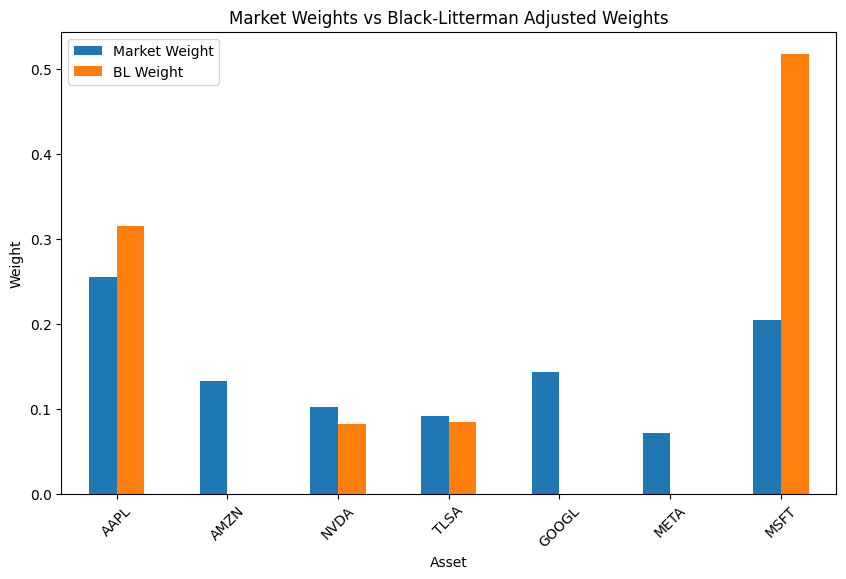

In [21]:
import matplotlib.pyplot as plt

# Calculate initial market weights
market_weights = {symbol: mcaps[symbol] / sum(mcaps.values()) for symbol in mcaps}

# Convert to DataFrame for plotting
market_weights_df = pd.DataFrame.from_dict(market_weights, orient='index', columns=['Market Weight'])
bl_weights_df = bl_weights.rename(columns={'weight': 'BL Weight'})

# Combine both DataFrames
weights_df = market_weights_df.join(bl_weights_df)

# Plot the weights
weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Market Weights vs Black-Litterman Adjusted Weights')
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.xticks(rotation=45)
plt.show()

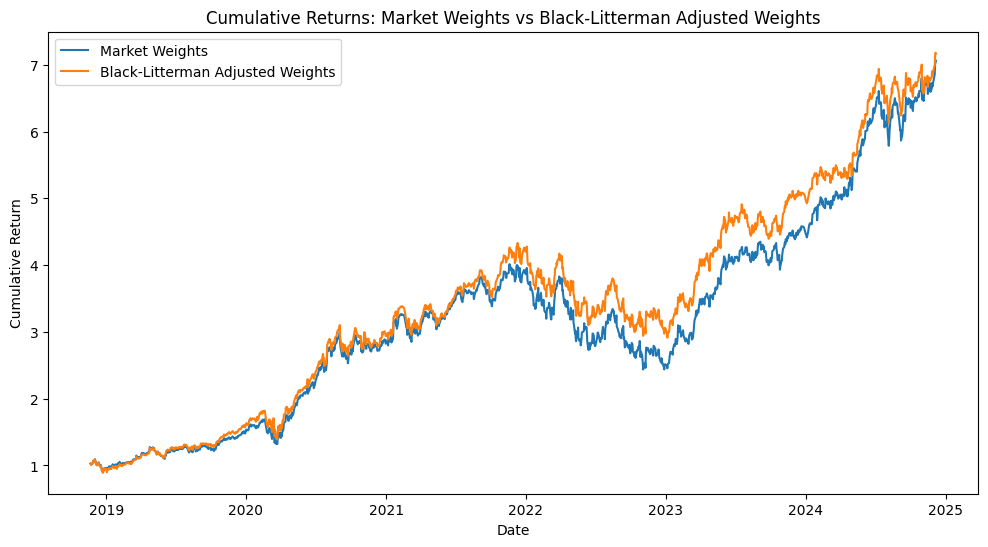

In [22]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for market weights
market_cumulative_returns = (prices.pct_change().dot(pd.Series(market_weights)) + 1).cumprod()

# Calculate cumulative returns for Black-Litterman adjusted weights
bl_cumulative_returns = (prices.pct_change().dot(bl_weights['weight']) + 1).cumprod()

# Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(market_cumulative_returns, label='Market Weights')
plt.plot(bl_cumulative_returns, label='Black-Litterman Adjusted Weights')
plt.title('Cumulative Returns: Market Weights vs Black-Litterman Adjusted Weights')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

In [23]:
weights_df

,Market Weight,BL Weight
AAPL,0.255102,0.314938
AMZN,0.132653,0.000000
NVDA,0.102041,0.082287
TLSA,0.091837,0.084744
GOOGL,0.142857,0.000000
META,0.071429,0.000000
MSFT,0.204082,0.518031
